# Чтение данных

In [100]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

wavfiles_dir = "data/archive/wavfiles/"
wavfiles = os.listdir(wavfiles_dir)
metadata = pd.read_csv("data/archive/bird_songs_metadata.csv")
metadata.head()

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [101]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB


In [102]:
birds = sorted(list(metadata['name'].unique()))
birds

['American Robin',
 "Bewick's Wren",
 'Northern Cardinal',
 'Northern Mockingbird',
 'Song Sparrow']

# Обработка данных

In [103]:
bird_to_audios = {}

for bird_name in birds:
    bird_to_audios[bird_name] = []

# all 'name' and 'filename' in metadata are not null
names = metadata['name']
filenames = metadata['filename']
for i in range(len(metadata)):
    bird_to_audios[names[i]].append(filenames[i])

for name, files in bird_to_audios.items():
    print(name, len(files))

bird_to_audios[birds[0]][:10]

American Robin 1017
Bewick's Wren 893
Northern Cardinal 1074
Northern Mockingbird 1182
Song Sparrow 1256


['564545-0.wav',
 '564545-4.wav',
 '564545-5.wav',
 '564545-6.wav',
 '564545-7.wav',
 '564545-8.wav',
 '564545-9.wav',
 '564545-10.wav',
 '564545-11.wav',
 '564545-13.wav']

In [104]:
import torchaudio
import torch

lfcc_transform = torchaudio.transforms.LFCC()
lfcc_transform

LFCC(
  (amplitude_to_DB): AmplitudeToDB()
  (Spectrogram): Spectrogram()
)

In [105]:
bird_to_speechs = {}
all_speechs = []
SIZE = 50

for name, files in bird_to_audios.items():
    speechs = []
    for file in files[:SIZE]:
        file_path = wavfiles_dir + file
        wave, _ = librosa.load(file_path)
        res_audio = lfcc_transform(torch.Tensor(wave))
        res_audio = res_audio.mean(dim=1)
        speechs.append(res_audio)
        all_speechs.append(res_audio)

    bird_to_speechs[name] = speechs

In [106]:
all_speechs[0].shape

torch.Size([40])

In [107]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
bird_to_speechs_tsne = {}

for name, files in bird_to_audios.items():
    bird_to_speechs_tsne[name] = tsne.fit_transform(torch.stack(bird_to_speechs[name]))

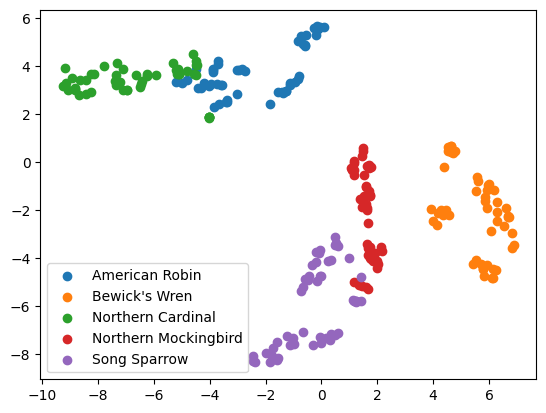

In [108]:
for i, name in enumerate(birds):
    plt.scatter(bird_to_speechs_tsne[name][:, 0], bird_to_speechs_tsne[name][:, 1], label=name)

plt.legend(loc="lower left")
plt.show()

In [109]:
all_speechs = tsne.fit_transform(torch.stack(all_speechs))
all_speechs[:5]

array([[-13.87551   ,   2.7404554 ],
       [-16.090248  ,   0.5938772 ],
       [-16.077744  ,   0.51598144],
       [-16.147568  ,   0.1440445 ],
       [-16.718256  ,  -0.72491014]], dtype=float32)

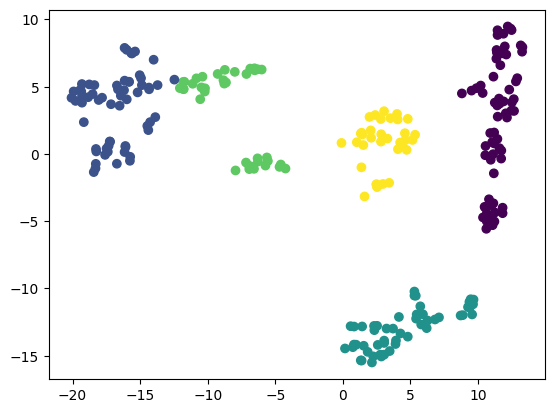

In [110]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, max_iter=250, n_init=10)
kmeans.fit(all_speechs)
labels = kmeans.predict(all_speechs)

plt.scatter(all_speechs[:, 0], all_speechs[:, 1], c=labels)

In [111]:
from scipy.spatial.distance import cosine

min_d = np.inf
similar = []

for i in range(len(birds)):
    for j in range(i + 1, len(birds)):
        d = 0
        name1 = birds[i]
        name2 = birds[j]
        speechs1 = bird_to_speechs[name1]
        speechs2 = bird_to_speechs[name2]

        for s1 in speechs1:
            for s2 in speechs2:
                d += cosine(s1, s2)

        d /= (len(speechs1) * len(speechs2))
        if d < min_d:
            min_d = d
            similar = [name1, name2]

similar

["Bewick's Wren", 'Song Sparrow']

In [112]:
from IPython.display import display

display(Audio(wavfiles_dir + bird_to_audios[similar[0]][123]))
display(Audio(wavfiles_dir + bird_to_audios[similar[1]][123]))